# Topological analyses Set 2

In [1]:
import os

import itertools
from collections import defaultdict


import networkx as nx

##### PyBEL imports

In [2]:
import pybel

from pybel.struct import get_subgraph_by_annotation_value
from pybel.struct.summary import count_functions

pybel.get_version()

'0.13.2'

##### PathMe import 

In [3]:
from pathme.constants import REACTOME_BEL, KEGG_BEL, WIKIPATHWAYS_BEL, PATHME_DIR
from pathme.export_utils import to_gml

##### DiffuPath import 

In [4]:
from diffupath.constants import DATA_DIR
from diffupath.validation_datasets_parsers import parse_set2

from diffupath.pathme_importer import get_labels_by_db_and_omic_from_pathme, get_labels_by_db_and_omic_from_graph
from diffupath.input_mapping import get_mapping, get_mapping_subsets, get_mapping_two_dim_subsets
from diffupath.utils import print_dict_dimensions, get_labels_set_from_dict, reduce_dict_dimension, get_count_and_labels_from_two_dim_dict, from_pickle, to_pickle, get_three_venn_intersections, random_disjoint_intersection_three_subsets
from diffupath.views import show_heatmap


## 1. Load Data Set 1: Input Scores

In [5]:
dataset2_labels_by_omics = parse_set2(os.path.join(DATA_DIR, 'validation_datasets', 'set2.xlsx'))
dataset2_all_labels = get_labels_set_from_dict(dataset2_labels_by_omics)
print_dict_dimensions(dataset2_labels_by_omics, 'Dataset2 imported labels:')

Dataset2 imported labels:
Total number of metabolite: 60  
Total number of genes: 31  
Total number of micrornas: 16  
Total: 107 


In [6]:
mirnas_dataset =  dataset2_labels_by_omics['micrornas']

## 2. Load Backrgound Network and Kernel matrix

### 2.1. Import PathMeUniverse network graph

In [7]:
pathme_universe_graph_no_flatten = pybel.from_pickle(os.path.join(DATA_DIR, 'pickles', 'universe', 'pathme_universe_bel_graph_no_flatten.bel.pickle'))
pathme_universe_graph_no_flatten.summarize()
count_functions(pathme_universe_graph_no_flatten)


PathMe Universe v1.0.0
Number of Nodes: 48643
Number of Edges: 104713
Number of Citations: 7696
Number of Authors: 0
Network Density: 4.43E-05
Number of Components: 6860
Number of Warnings: 0


Counter({'Composite': 1605,
         'Abundance': 7046,
         'BiologicalProcess': 2857,
         'Complex': 9048,
         'Reaction': 13576,
         'Gene': 14511})

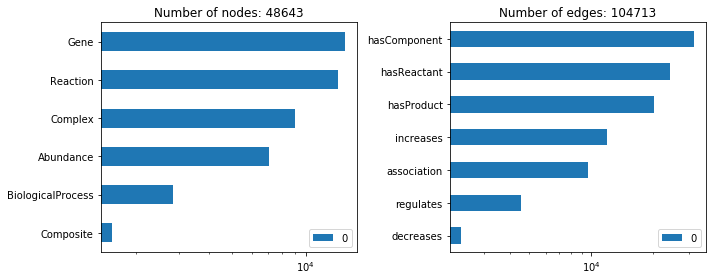

In [8]:
import matplotlib.pyplot as plt
from pybel_tools.summary import plot_summary, count_top_centrality
plot_summary(pathme_universe_graph_no_flatten, plt, figsize=(10, 4))
plt.show()

##### Check and filter isolates / Unconnected nodes

In [9]:
nx.number_of_isolates(pathme_universe_graph_no_flatten)

6426

In [10]:
pathme_universe_graph_no_flatten.remove_nodes_from({
    node
    for node in nx.isolates(pathme_universe_graph_no_flatten)
})

### 2.2. Get KEGG subgraph from PathMeUniverse graph

In [11]:
kegg_pathme_graph_no_flatten = get_subgraph_by_annotation_value(pathme_universe_graph_no_flatten, 'database', 'kegg')
kegg_pathme_graph_no_flatten.summarize()
count_functions(kegg_pathme_graph_no_flatten)

None vNone
Number of Nodes: 13162
Number of Edges: 35122
Number of Citations: 2
Number of Authors: 0
Network Density: 2.03E-04
Number of Components: 65
Number of Warnings: 0


Counter({'Composite': 1596,
         'Complex': 406,
         'Gene': 6149,
         'Abundance': 1762,
         'Reaction': 3137,
         'BiologicalProcess': 112})

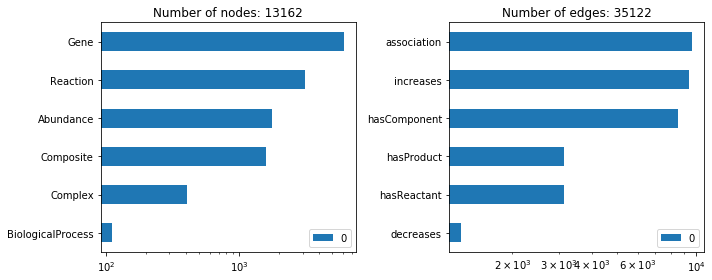

In [12]:
import matplotlib.pyplot as plt
from pybel_tools.summary import plot_summary, count_top_centrality
plot_summary(kegg_pathme_graph_no_flatten, plt, figsize=(10, 4))
plt.show()

### 2.3. Get entity labels subsets by entity type (omic) and by database

#####  2.3.2.  From PathMeUniverse KEGG subgraph

In [13]:
bg_labels_from_pathmeuniverse_by_db_and_omic, bg_labels_from_pathmeuniverse_by_omic_and_db =  get_labels_by_db_and_omic_from_graph(kegg_pathme_graph_no_flatten)

print_dict_dimensions(bg_labels_from_pathmeuniverse_by_db_and_omic, 'Entities in PathMeUniverse :')

Entities in PathMeUniverse :
Total number of kegg: gene_nodes(6027), mirna_nodes(122), metabolite_nodes(1762), bp_nodes(112),  
Total: 8023 


In [14]:
bg_labels_from_pathmeuniverse_by_omic = reduce_dict_dimension(bg_labels_from_pathmeuniverse_by_omic_and_db)

### 2.4. Get Background  Matrix Kernel

In [15]:
kernel_path = os.path.join(DATA_DIR, 'pickles', 'by_db_validation', 'regularised_laplacian_kernel_kegg.pickle')

##### Generate kernel OR load from pickle

DiffuPy to generate laplacian_kernel

In [16]:
#import diffupy
#from diffupy.kernels import regularised_laplacian_kernel

In [17]:
#background_mat = regularised_laplacian_kernel(kegg_pathme_graph_no_flatten)
#to_pickle(regularised_laplacian_kernel, kernel_path)

Import kernel from pickle

In [18]:
background_mat = from_pickle(kernel_path)

## 3. Dataset label mapping to PathMeEntities

##### All kernel matrix (background network) row labels for the mapping

In [19]:
background_labels = background_mat.rows_labels

### 3.1. General mapping

In [21]:
all_labels_mapping = get_mapping(dataset2_all_labels, background_labels, title = 'Global mapping: ', mirnas = mirnas_dataset, print_percentage = True)


Global mapping:  (31) 29.245283018867923%


### 3.2. Mapping by subsets

#### 3.2.1. Mapping by entity type/omic

In [22]:
mapping_by_entity, _, _ = get_mapping_subsets(dataset2_labels_by_omics, background_labels, 'entity type/omic', mirnas = mirnas_dataset)


Mapping by entity type/omic:
metabolite (4) 6.666666666666667%
genes (27) 87.09677419354838%
micrornas (6) 37.5%
Total (37) 34.90566037735849% 



In [23]:
micrornas_mapping = mapping_by_entity['micrornas'][0]

#### 3.2.2. Mapping by database

In [24]:
background_entites_by_db = {db : set(itertools.chain.from_iterable(entities.values())) for db, entities in bg_labels_from_pathmeuniverse_by_db_and_omic.items()}
mapping_by_db, _, _ = get_mapping_subsets(background_entites_by_db, dataset2_all_labels, 'database', mirnas = mirnas_dataset, submapping = background_labels, mirnas_mapping = micrornas_mapping, percentage_reference_labels = True)


Mapping by database:
kegg (37) 34.90566037735849%
Total (37) 34.90566037735849% 



#### 3.2.3. Mapping by entity type and database (two dimentions)

In [25]:
mapping_by_database_and_entity, total_percentage, total_dimention = get_mapping_two_dim_subsets(bg_labels_from_pathmeuniverse_by_db_and_omic, dataset2_all_labels, relative_statistics = dataset2_labels_by_omics, mirnas_mapping = micrornas_mapping)


Mapping by Kegg:
gene_nodes (26) 83.87096774193549%
mirna_nodes (6) 37.5%
metabolite_nodes (5) 8.333333333333332%
bp_nodes (0) 0%
Total (37) 0.461174124392372% 

Total (37) 34.90566037735849% 



### 3.3. Mapping descriptive view

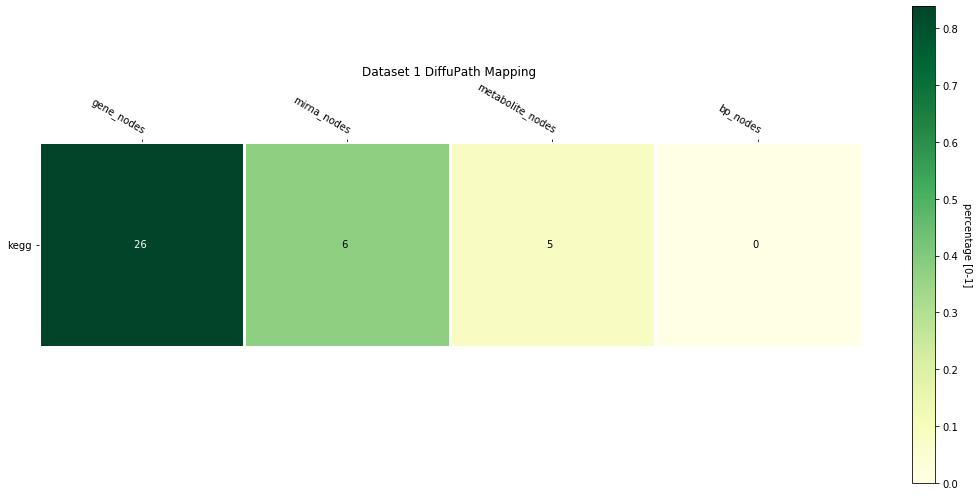

In [26]:
count, percentage, db_labels, entity_labels  = get_count_and_labels_from_two_dim_dict(mapping_by_database_and_entity)

show_heatmap(count, percentage, db_labels, entity_labels)


## 4. Resistance distance

In [27]:
from diffupath.topological_analyses import resistance_distance, filter_quadratic_mat_by_mapping
from diffupath.cross_validation import cross_validation_one_x_in

from diffupath.views import box_plot_from_two_dimension_dict
from diffupath.utils import get_mean_from_two_dim_dict

In [28]:
ER = resistance_distance(kegg_pathme_graph_no_flatten)

/Users/jmarinllao/Documents/Projectes/MultiPath/DiffuPy/src/diffupy/utils.py:20: UserWarning:

Since graph is directed, it will be converted to an undirected graph.



In [30]:
d_resistance_distance = filter_quadratic_mat_by_mapping(ER, mapping_by_entity)
d_resistance_distance_mean = get_mean_from_two_dim_dict(d_resistance_distance)

In [31]:
from diffupath.views import box_plot_from_dict, box_plot_from_two_dimension_dict

In [32]:
box_plot_from_two_dimension_dict(d_resistance_distance_mean, 'Resitance distance', 'Resitance distance')

/usr/local/Cellar/ipython/7.2.0/libexec/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [33]:
box_plot_from_dict(d_resistance_distance_mean['genes'], 'Genes', 'Resitance distance')

In [34]:
box_plot_from_dict(d_resistance_distance_mean['micrornas'], 'Micrornas', 'Resitance distance')

In [35]:
box_plot_from_dict(d_resistance_distance_mean['metabolite'], 'Metabolite', 'Resitance distance')

## 5. PageRank Centrality

In [40]:
from diffupath.topological_analyses import generate_pagerank_baseline
from statistics import mean

In [37]:
scores_page_rank = generate_pagerank_baseline(kegg_pathme_graph_no_flatten, background_mat)

In [38]:
d_page_rank = defaultdict(lambda: list())

for k1, v1 in mapping_by_entity.items():
    for e1 in v1[0]:
        d_page_rank[k1].append(scores_page_rank.get_cell_from_labels(e1, 'PageRank'))

In [41]:
d_page_rank_mean = {k1 : [mean(v1)] for k1, v1 in d_page_rank.items()}

In [42]:
box_plot_from_dict(d_page_rank_mean, 'Pagerank', 'Centrality study')

In [43]:
box_plot_from_dict(d_page_rank, 'Pagerank', 'Centrality study')